In [ ]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm

In [11]:
# Set working directory
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import call_spread_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [26]:
# ---------------------------------------------------------------------------
# 2) Optional: Model Hedge (e.g. Black-Scholes Call Spread) function
# ---------------------------------------------------------------------------
def black_scholes_call_spread_delta(S0, K1, K2, T, sigma):
    """
    Computes delta for a call spread using Black-Scholes formula.
    The call spread consists of:
    - A long call at strike K1
    - A short call at strike K2
    """
    def black_scholes_call_price_delta(S0, K, T, sigma):
        d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
        return norm.cdf(d1)

    delta_K1 = black_scholes_call_price_delta(S0, K1, T, sigma)
    delta_K2 = black_scholes_call_price_delta(S0, K2, T, sigma)
    
    return delta_K1 - delta_K2  # Call spread delta = Long call delta - Short call delta

def compute_model_hedge_pnl_spread(q, Z, delta_const, S_paths):
    """
    Frictionless PnL for a call spread hedge:
    PnL = q - Z + delta_const * sum_{k=0}^{n-1} [S_{k+1}-S_k].
    """
    S_diff = S_paths[:,1:] - S_paths[:,:-1]  # shape (n_paths, n_steps)
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl


In [27]:
# ----------------------------------------------------------------------------
# 3) Simulation Setup for Call Spread
# ----------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365  # 30 days

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
print("Simulated S_paths shape:", S_paths_np.shape)

# Define call spread strikes
K1, K2 = 100.0, 105.0

# Compute call spread payoff instead of single call option
Z_np = call_spread_payoff(S_paths_np, K1=K1, K2=K2)
print("Call Spread Payoff shape:", Z_np.shape)

# Convert to torch tensors
S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)


Simulated S_paths shape: (200000, 31)
Call Spread Payoff shape: (200000,)


In [28]:
# ----------------------------------------------------------------------------
# 4) Model Hedge for Call Spread
# ----------------------------------------------------------------------------
sigma_guess = 0.2

# Compute Black-Scholes call spread hedge delta
delta_bs_spread = black_scholes_call_spread_delta(S0=100.0, K1=K1, K2=K2, T=T, sigma=sigma_guess)

# Compute initial price estimate for call spread hedge
q_bs_spread = delta_bs_spread  # The initial hedge position

# Compute model hedge PnL for call spread
model_pnl_spread = compute_model_hedge_pnl_spread(q_bs_spread, Z_np, delta_bs_spread, S_paths_np)

print("Call Spread Model Hedge Stats:")
print("  mean PnL =", model_pnl_spread.mean())
print("  std PnL  =", model_pnl_spread.std())

Call Spread Model Hedge Stats:
  mean PnL = -0.05058210391871218
  std PnL  = 1.4074807378717589


In [29]:
# ----------------------------------------------------------------------------
# 5) Train Recurrent Hedge under CVaR alpha=0.5 for Call Spread
# ----------------------------------------------------------------------------
import torch

# Ensure tensors are on the correct device
S_torch = S_torch.to(device)
Z_torch = Z_torch.to(device)

# Define CVaR risk level
alpha = 0.5  

# Ensure num_steps is defined
num_steps = S_torch.shape[1] - 1  

# Initialize Recurrent Hedge Model (now using shared architecture)
recurrent_model_spread = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

# Use the updated DeepHedgeCVaRTrainer
trainer_rec_spread = DeepHedgeCVaRTrainer(
    model=recurrent_model_spread, 
    loss_function="cvar", 
    alpha=alpha
)

# Train the model for Call Spread
p0_rec_spread = trainer_rec_spread.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs_spread,  # Use the call spread initial hedge
    n_epochs=5,
    batch_size=4096
)

print(f"Recurrent Hedge Price for Call Spread p0_rec_spread = {p0_rec_spread:.4f}")

# Evaluate model performance (no gradient computation needed)
with torch.no_grad():
    deltas_rec_spread = recurrent_model_spread(S_torch)
    Sdiff_spread = S_torch[:, 1:] - S_torch[:, :-1]  
    gains_rec_spread = torch.sum(deltas_rec_spread * Sdiff_spread, dim=1)
    pnl_rec_spread = (trainer_rec_spread.p0 - Z_torch + gains_rec_spread).cpu().numpy()


Epoch 1/5 | Loss: 2.6973 | p0: 0.3060
Epoch 2/5 | Loss: 0.2803 | p0: 0.3060
Epoch 3/5 | Loss: 0.3801 | p0: 0.3060
Epoch 4/5 | Loss: 0.2365 | p0: 0.3060
Epoch 5/5 | Loss: 0.3798 | p0: 0.3060
Recurrent Hedge Price for Call Spread p0_rec_spread = 0.3060


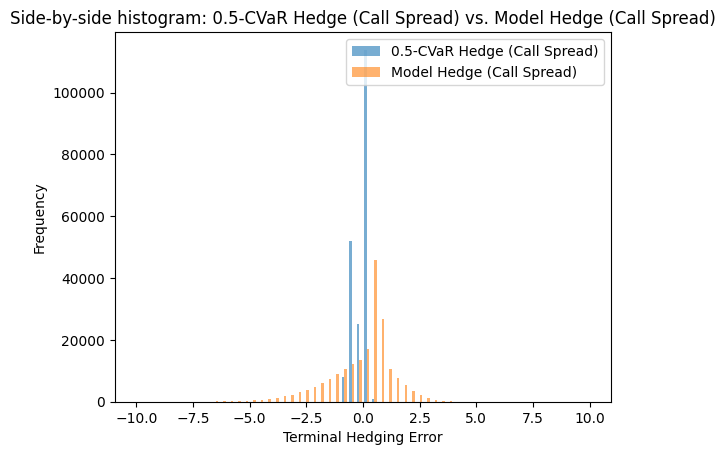

In [30]:
# ----------------------------------------------------------------------------
# 7) Figures for Call Spread
# ----------------------------------------------------------------------------

def plot_side_by_side_hist_spread(pnl1, pnl2, label1="CVaR Hedge (Call Spread)", label2="Model Hedge (Call Spread)",
                                  bins=50, range=(-10,10)):
    """
    Plot side-by-side histogram bars for two PnL arrays, over the same bins for call spread hedge.
    
    Args:
      pnl1, pnl2: 1D arrays of data.
      label1, label2: legend labels for the two sets of bars.
      bins: int or sequence of bin edges
      range: (min, max) range for the histogram
    """
    # 1) Manually compute hist counts for each distribution
    counts1, edges = np.histogram(pnl1, bins=bins, range=range)
    counts2, _     = np.histogram(pnl2, bins=edges)  # use same edges for second data
    
    # 3) Compute bin centers
    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0  # bar width is 1/3 of bin width

    # 4) Shift one bar group left, the other right
    plt.bar(
        centers - width/2, counts1, width=width,
        alpha=0.6, label=label1, color='tab:blue'
    )
    plt.bar(
        centers + width/2, counts2, width=width,
        alpha=0.6, label=label2, color='tab:orange'
    )
    
    # 5) Label and show
    plt.xlabel("Terminal Hedging Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Side-by-side histogram: {label1} vs. {label2}")
    plt.show()

# Plot histogram for call spread hedge
plot_side_by_side_hist_spread(pnl_rec_spread, model_pnl_spread,
                              label1="0.5-CVaR Hedge (Call Spread)", label2="Model Hedge (Call Spread)",
                              bins=60, range=(-10,10))


In [42]:
# ----------------------------------------------------------------------------
# Generate Delta Surface Plots for Call Spread (Replicating Figure 8 & 9)
# ----------------------------------------------------------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a grid of spot prices and volatilities
S_grid = np.linspace(90, 110, 50)  # Spot prices from 90 to 110
V_grid = np.linspace(0.01, 0.2, 50)  # Variance from 0.01 to 0.2
S_mesh, V_mesh = np.meshgrid(S_grid, V_grid)

# Convert grid to tensors
S_input = torch.tensor(S_mesh.flatten()).float().to(device)
V_input = torch.tensor(V_mesh.flatten()).float().to(device)

# Predict hedge ratios using the trained recurrent hedge model for call spread
# with torch.no_gra

# Ensure the input is expanded to match the expected time-series format
# S_input_expanded = S_input.view(-1, num_steps, 1)  # Reshape to (batch_size, num_steps, 1)

# with torch.no_grad():
#     delta_pred_spread = recurrent_model_spread(S_input_expanded).cpu().numpy()

# with torch.no_grad():
#     delta_pred_spread = simple_model_spread(torch.stack([S_input, V_input], dim=1)).cpu().numpy()


# Ensure input is correctly expanded for time-series processing
batch_size = S_input.shape[0]  

# Expand S_input and V_input to match the expected recurrent model format
S_input_expanded = S_input.unsqueeze(1).repeat(1, num_steps, 1)  # (batch_size, num_steps, 1)
V_input_expanded = V_input.unsqueeze(1).repeat(1, num_steps, 1)  # (batch_size, num_steps, 1)

# Stack them along the last dimension to form (batch_size, num_steps, input_dim)
S_V_input = torch.cat([S_input_expanded, V_input_expanded], dim=2)  # Shape: (batch_size, num_steps, 2)

# Predict hedge ratios using the trained recurrent hedge model for call spread
with torch.no_grad():
    delta_pred_spread = recurrent_model_spread(S_V_input).cpu().numpy()







# Reshape predictions to match the grid
delta_pred_spread = delta_pred_spread.reshape(S_mesh.shape)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

NameError: name 'delta_pred_spread' is not defined

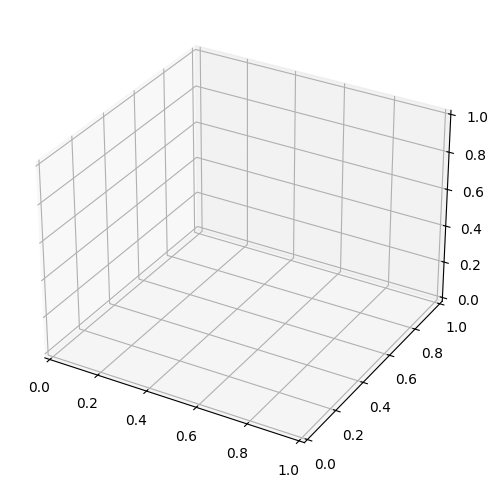

In [32]:
# ----------------------------------------------------------------------------
# Figure 8: Deep Hedging Call Spread Delta Surface
# ----------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, V_mesh, delta_pred_spread, cmap='viridis')

# Labels
ax.set_xlabel('Spot Price (S)')
ax.set_ylabel('Variance (V)')
ax.set_zlabel('Hedge Ratio (Delta)')
plt.title("Deep Hedging Call Spread Delta Surface")

plt.show()


In [ ]:
# Compute Black-Scholes hedge deltas for the same (S, V) grid
sigma_guess = 0.2  # Approximate market volatility
delta_bs_spread_grid = np.array([
    black_scholes_call_spread_delta(S, K1=100.0, K2=105.0, T=T, sigma=sigma_guess)
    for S in S_input.cpu().numpy()
]).reshape(S_mesh.shape)

In [ ]:
# ----------------------------------------------------------------------------
# Figure 9: Comparison of Deep Hedging vs. Black-Scholes Hedge Ratios
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))

# Contour plot for Black-Scholes Model Hedge
contour1 = ax.contour(S_mesh, V_mesh, delta_bs_spread_grid, levels=15, cmap='coolwarm')
ax.clabel(contour1, inline=True, fontsize=8)

# Contour plot for Deep Hedging Hedge
contour2 = ax.contour(S_mesh, V_mesh, delta_pred_spread, levels=15, cmap='viridis', alpha=0.7)
ax.clabel(contour2, inline=True, fontsize=8)

# Labels
ax.set_xlabel('Spot Price (S)')
ax.set_ylabel('Variance (V)')
plt.title("Deep Hedging vs. Black-Scholes Hedge Ratios for Call Spread")

plt.legend(["Black-Scholes Hedge", "Deep Hedge Model"])
plt.show()